# Load Packages

In [120]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# Basic Functions

In [121]:
def style_plot():
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # Set linewidth of remaining spines to 2
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    # Remove ticks
    plt.tick_params(left = False, bottom = False)
    # Grid and legend
    plt.grid()
    plt.legend()

def sigmoid(x: float|np.ndarray[np.float64], vhalf: float, k: float
            ) -> float|np.ndarray[np.float64]:
    """Goal:
        Return the sigmoid function for a given x, vhalf, and k.
    --------------------------------------------------------------------
    Parameters:
        x: Membrane voltage [mV].
        vhalf: The half-maximum voltage [mV].
        k: The slope factor [mV]
    --------------------------------------------------------------------
    Returns:
        The sigmoid function for a given x, vhalf, and k.
    """
    return 1 / (1 + np.exp(-(x - vhalf) / k))


# Functions for the Markov Model

In [122]:
@njit(fastmath = True)
def transition_matrix(Vm: np.float64) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the transition matrix of the Markov model for the
        Kv11 channel at a given voltage Vm.
        
        Adapted from the KV11.1 Markov model described in:
            Mazhari R, Greenstein JL, Winslow RL, Marbán E, Nuss HB. 
            Molecular interactions between two long-QT syndrome gene products, 
            HERG and KCNE2, rationalized by in vitro and in silico analysis. 
            Circ Res. 2001 Jul 6;89(1):33-8. doi: 10.1161/hh1301.093633. 
            PMID: 11440975.
    ---------------------------------------------------------------------------
    Input:
        Vm: Membrane voltage [mV]
    ---------------------------------------------------------------------------
    Output:
        Q: Transition matrix of the Markov model [s^-1]"""
    # Transition rates [ms^-1]
    # 5 States; 3 closed (C1, C2, C3), a transition state (I) and an open state (O)
    # C1 - C2 - C3 - O
    #            \  /
    #              I    
    C1C2 = 0.0069 * np.exp(0.0272 * Vm) # Symbol in the paper --> a0
    C2C1 = 0.0227 * np.exp(-0.0431 * Vm) # b0
    C3O = 0.0218 * np.exp(0.0262 * Vm) # a1
    OC3 = 0.0009 * np.exp(-0.0269 * Vm) # b1
    OI = 0.0622 * np.exp(0.0120 * Vm) # ai
    IO = 0.0059 * np.exp(-0.0443 * Vm) # bi
    C2C3 = 0.0266 # kf
    C3C2 = 0.1348 # kb
    C3I = 1.29E-5 * np.exp(2.71E-6 * Vm) # ai3
    IC3 = (OC3 * IO * C3I) / (C3O * OI) # Greek letter

    # Transition matrix
    Q = np.zeros((5, 5), dtype = np.float64)
    Q[0, 0] = -C1C2 # C1
    Q[0, 1] = C2C1
    Q[1, 0] = C1C2 # C2
    Q[1, 1] = -(C2C1 + C2C3)
    Q[1, 2] = C3C2
    Q[2, 2] = -(C3C2 + C3O + C3I) # C3
    Q[2, 1] = C2C3
    Q[2, 3] = OC3
    Q[2, 4] = IC3
    Q[3, 3] = -(OC3 + OI) # O
    Q[3, 2] = C3O
    Q[3, 4] = IO
    Q[4, 4] = -(IO + IC3) # I
    Q[4, 2] = C3I 
    Q[4, 3] = OI
    
    return Q * 1000 # ms^-1 to s^-1


def steady_state(Vm: np.float64) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the steady state probabilities of the Markov model
        for the Kv11 channel at a given voltage Vm.
    ---------------------------------------------------------------------------
    Input:
        Vm: Membrane voltage [mV]
    ---------------------------------------------------------------------------
    Output:
        steady_state: Steady state probabilities of the Markov model
    """
    # Create transition matrix and adapt the last row in such a way that all
    # have weight 1
    Q = transition_matrix(Vm)
    Q[-1, :] = 1
    # Solve the linear system --> last equation ensures that sum of probabilities is 1
    b = np.array([0, 0, 0, 0, 1])
    steady_state = np.linalg.solve(Q, b)
    return steady_state

@njit(fastmath = True)
def kv11(t: np.float64, y: np.ndarray[np.float64], Vm: np.float64) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the derivative of the state probabilities of the
        Kv11 channel at a given voltage Vm.
    ---------------------------------------------------------------------------
    Input:
        t: Time [s]
        y: State probabilities of the Markov model
        Vm: Membrane voltage [mV]
    ---------------------------------------------------------------------------
    Output:
        dydt: Derivative of the state probabilities of the Markov model
    """
    Q = transition_matrix(Vm)
    return Q @ y


# Protocol 1: Measure Peak Tail Current's Voltage Dependence

In [123]:
def pktailcurr_Vm(
        Vmclamp: float = -80.0, 
        Vmpre: np.ndarray[float] = np.arange(-80, 61, 10),
        dpre: float = np.array([3.5]),
        Vmtest: float = -50, 
        dtest: float = 0.5,
        dt = 0.0001,
        Ek: float = -82.0
        ) -> np.ndarray[float]:
    """Goal:
        This function returns the peak tail currents of the Kv11 channel for a
        given voltage clamp protocol. The protocol consists of a pre-pulse at
        Vmpre [mV] for 'dpre' seconds, followed by a test pulse at Vmtest [mV] for
        'dtest' seconds. The membrane voltage is clamped at Vmclamp [mV] before.
    ---------------------------------------------------------------------------
    Input:
        Vmclamp: Membrane voltage [mV]
        Vmpre: Voltage of the pre-pulse [mV]
        dpre: Duration(s) of the pre-pulse [s]
        Vmtest: Voltage of the test pulse [mV]
        dtest: Duration of the test pulse [s]
        dt: Time step [s]
        Ek: Potassium reversal potential [mV]
    ---------------------------------------------------------------------------
    Output:
        peak_tail_currents: Peak tail currents of the Kv11 channel for the given
        voltage clamp protocol.
    """
    # Set time [s]
    t_test_span = (0, dtest)
    t_test = np.arange(t_test_span[0], t_test_span[1], dt)

    # Get y0
    y0 = steady_state(Vmclamp)

    # Perform the simulation
    y0 = steady_state(Vmclamp)
    peak_tail_currents = np.empty((Vmpre.shape[0], dpre.shape[0]))
    for iVm, Vm in enumerate(Vmpre):
        for iduration, duration in enumerate(dpre):
            # Solve ODEs
            sol = solve_ivp(
                kv11, (0, duration), y0.copy(), args=(Vm,), 
                t_eval = np.arange(0, duration, dt), method='RK45'
                )
            sol = solve_ivp(
                kv11, t_test_span, sol.y[:, -1], args=(Vmtest,), 
                t_eval = t_test, method='RK45'
                )
            # Append the peak tail current
            peak_tail_currents[iVm, iduration] = max(sol.y[3, :] * (Vmtest - Ek))
    
    return peak_tail_currents


C:\Users\niels\AppData\Local\Temp\ipykernel_33176\3167945056.py:91: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  return Q @ y
C:\Users\niels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\typing\npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


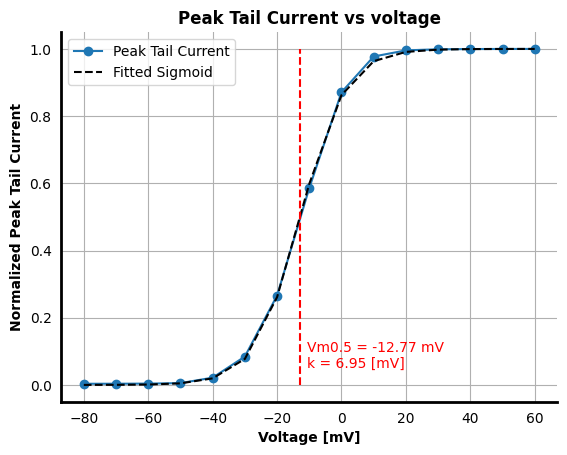

In [124]:
# ----- Parameters
Vmclamp = -80.0 # [mV]
Vmpre = np.arange(-80, 61, 10) # [mV]
dpre = np.array([3.5]) # [s]
Vmtest = -50 # [mV] 
dtest = 0.5 # [s]
dt = 0.0001 # [s]
Ek = -82.0 # [mV]

# Get peak tail currents
peak_tail_currents = pktailcurr_Vm(
    Vmclamp = Vmclamp, Vmpre = Vmpre, dpre = dpre, Vmtest = Vmtest, 
    dtest = dtest, dt = dt, Ek = Ek
    )
peak_tail_currents = peak_tail_currents[:, 0]
# Fit sigmoid
popt, _ = curve_fit(sigmoid, Vmpre, peak_tail_currents / max(peak_tail_currents))

# Plot
plt.plot(Vmpre, peak_tail_currents / max(peak_tail_currents), 'o-', label = 'Peak Tail Current')
plt.plot(Vmpre, sigmoid(Vmpre, *popt), 'k--', label = 'Fitted Sigmoid')
plt.vlines(popt[0], 0, 1, 'r', '--')
plt.text(
    popt[0] + 2, 0.05, 
    f'Vm0.5 = {popt[0].round(2)} mV\nk = {popt[1].round(2)} [mV]', color = 'r'
    )

plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Normalized Peak Tail Current', fontweight = 'bold')
plt.title('Peak Tail Current vs voltage', fontweight = 'bold')
style_plot()
plt.show()

# Protocol 2: Activation Kinetics

In [125]:
np.linspace(0.035, 0.49, 10)

array([0.035     , 0.08555556, 0.13611111, 0.18666667, 0.23722222,
       0.28777778, 0.33833333, 0.38888889, 0.43944444, 0.49      ])

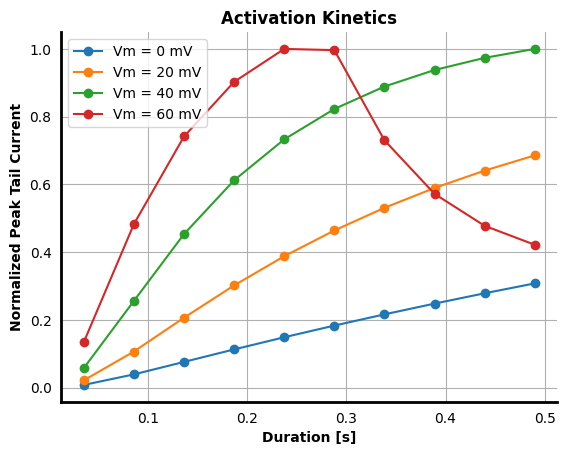

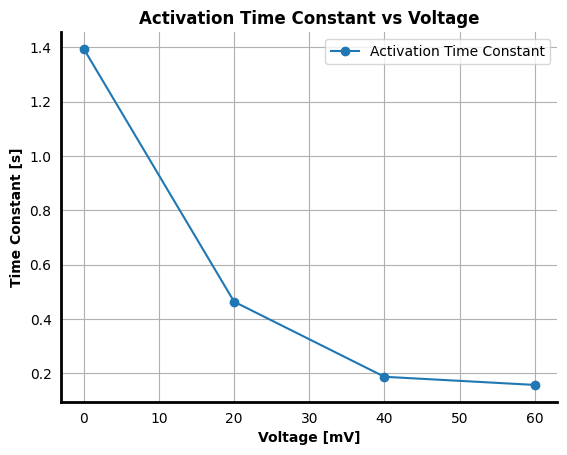

In [126]:
# def activation_kinetics(
#         Vmclamp: float = -80.0, Vmpre: np.ndarray[float] = np.arange(0, 61, 20),
#         dpre: np.ndarray[float] = np.array(
#             [
#                 0.035, 0.08555556, 0.13611111, 0.18666667, 0.23722222,
#                 0.28777778, 0.33833333, 0.38888889, 0.43944444, 0.49, 10
#                 ]
#             ),
#         Vmtest: float = -120, dtest: float = 0.2, dt: float = 0.0001, 
#         Ek: float = -82.0
#         ) -> np.ndarray[float]:
#     """Goal:
#         This function returns the peak tail currents of the Kv11 channel for a
#         given voltage clamp protocol. The protocol consists of a pre-pulse at
#         Vmpre [mV] for 'dpre[i]' seconds, followed by a test pulse at Vmtest [mV] for
#         'dtest' seconds. We repeat this experiment for i durations 'dpre[i]'. 
#         The membrane voltage is clamped at Vmclamp [mV] before.
#     ----------------------------------------------------------------------------
#     Input:
#         Vmclamp: Membrane voltage [mV]
#         Vmpre: Voltage of the pre-pulse [mV]
#         dpre: Durations of the pre-pulses [s]
#         Vmtest: Voltage of the test pulse [mV]
#         dtest: Duration of the test pulse [s]
#         dt: Time step [s]
#         Ek: Potassium reversal potential [mV]
#     ----------------------------------------------------------------------------
#     Output:
#         act_data: Peak tail currents of the Kv11 channel for the given voltage
#         clamp for the given durations. (rows: Vmpre, columns: dpre)
#     """
#     # Time
#     t_test_span = (0, dtest)
#     t_test = np.arange(t_test_span[0], t_test_span[1], dt)

#     # Get the tail currents
#     act_data = np.empty((Vmpre.shape[0], dpre.shape[0]))
#     y0 = steady_state(Vmclamp)
#     for iVm, Vm in enumerate(Vmpre):
#         for iduration, duration in enumerate(dpre):
#             # Solve ODEs
#             sol = solve_ivp(
#                 kv11, (0, duration), y0.copy(), args=(Vm,), 
#                 t_eval=np.arange(0, duration, dt), method='RK45'
#                 )
#             sol = solve_ivp(
#                 kv11, t_test_span, sol.y[:, -1], args=(Vmtest,), 
#                 t_eval = t_test, method='RK45'
#                 )
#             act_data[iVm, iduration] = max(sol.y[3, :] * (Vm - Ek))
    
#     return act_data

def act_tau(act_data: np.ndarray[float], dpre: np.ndarray[float]) -> np.ndarray[float]:
    tauvals = np.empty(act_data.shape[0])
    for iv in range(act_data.shape[0]):
        popt, _ = curve_fit(
                lambda x, tau: fit_act(x, tau, max(act_data[iv, :])), 
                dpre, 
                act_data[iv, :], 
                p0 = [0.1]
                )
        tauvals[iv] = popt[0]
    return tauvals

def fit_act(duration, tau, peak_tail_currents):
    return peak_tail_currents * (1 - np.exp(-duration / tau))

# ----- Parameters
Vmclamp = -80.0 # [mV]
Vmpre = np.arange(0, 61, 20) # [mV]
dpre = np.array(
    [
        0.035, 0.08555556, 0.13611111, 0.18666667, 0.23722222,
        0.28777778, 0.33833333, 0.38888889, 0.43944444, 0.49, 10
        ]
    ) # [s]
Vmtest = -120 # [mV] 
dtest = 0.2 # [s]
dt = 0.0001 # [s]
Ek = -82.0 # [mV]

act_data = pktailcurr_Vm(
    Vmclamp = Vmclamp, Vmpre = Vmpre, dpre = dpre, Vmtest = Vmtest, 
    dtest = dtest, dt = dt, Ek = Ek
)
act_data = act_data / np.min(act_data, axis = 1)[:, None]
tauvals = act_tau(act_data, dpre)

# ---- Plot the tail currents
for iv in range(act_data.shape[0]):
    plt.plot(dpre[:-1], act_data[iv, :-1], 'o-', label = f'Vm = {Vmpre[iv]} mV')
plt.xlabel('Duration [s]', fontweight = 'bold')
plt.ylabel('Normalized Peak Tail Current', fontweight = 'bold')
plt.title('Activation Kinetics', fontweight = 'bold')
style_plot()
plt.legend()
plt.show()

# ---- Plot the time constants
plt.plot(Vmpre, tauvals, 'o-', label = 'Activation Time Constant')
plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Time Constant [s]', fontweight = 'bold')
plt.title('Activation Time Constant vs Voltage', fontweight = 'bold')
style_plot()
plt.show()

